In [13]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
# Every operation needs to be propogated backwards with its derivative
# Value class needs the value that holds a float
# - needs to overload the ops
# - needs to be able to get the grad of the final output wrt the current value

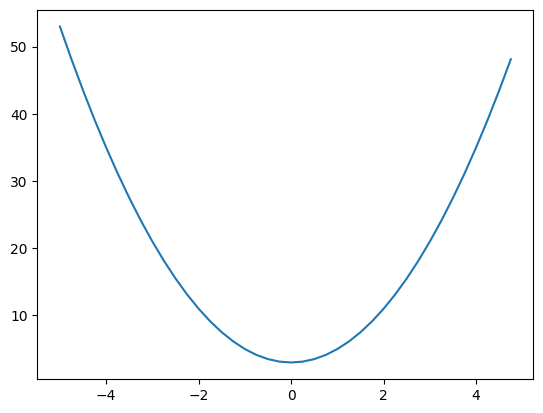

In [3]:
def f(x):
    return 2 * (x ** 2) + 3

xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [687]:
class Value:
    def __init__(self, data, _children = (), _op = "", label = "_no_label_", op_der = lambda: None):
        # Only two children for now and one operation
        self.data = data
        self.op_der = op_der
        self.grad = 0.0
        self.children = set(_children)
        self.op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data = {self.data})"

    def moredata(self):
        return f"Value(data = {self.data}, _children = {self.children}, _op = {self.op})"

    def __add__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
            
        out = Value(self.data + other.data, (self, other), "+")
        def _der():
            self.grad += out.grad
            other.grad += out.grad
        out.op_der = _der
        return out

    def __radd__(self, other):
        return self + other

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + -(other)

    def __mul__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
            
        out = Value(self.data * other.data, (self, other), "*")
        def _der():
            self.grad += other.data * out.grad 
            other.grad += self.data * out.grad
        out.op_der = _der
        return out

    def __rmul__(self, other):
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only int/float allowed"

        out = Value(self.data ** other, (self, ), f'**{other}')
        def _der():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out.op_der = _der
        return out

    def __truediv__(self, other):
        return self * (other ** -1)
        
    def __rtruediv__(self, other):
        return other * (self ** -1)
    
    def tanh(self):
        x = self.data
        # val = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        val = math.tanh(x)
        out = Value(val, (self, ), "tanh")
        def _der():
            self.grad += (1 - val**2) * out.grad
        out.op_der = _der
        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self, ), "relu")

        def _der():
            self.grad += (out.data > 0) * out.grad
        out.op_der = _der
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _der():
            self.grad += out.data * out.grad
        out.op_der = _der
        return out

    def trace(self, depth=1):
        print(f"{self.label}={self.data}", f"grad={self.grad}", self.op)
        
        for child in self.children:
            print(end="  "*depth)
            child.trace(depth+1)
    
    def pretty_trace(self, depth=1):
        if self.label != "_no_label_":
            print(f"{self.label}={self.data}", f"grad={self.grad}", self.op)
        
        for child in self.children:
            if self.label != "_no_label_":
                print(end="  "*depth)
                child.pretty_trace(depth+1)
            else:
                child.pretty_trace(depth)

    def backward(self):
        # Calculate the gradients wrt each children and recurse till no children
        # Each child node's grad will be with respect to self
        # To get each child node's global grad, we need to multiply with current grad

        # Calculate toposort of DAG and call backward for all the child nodes in that order
        topo = []
        visited = set()
        def build_topo(node):
            if node in visited:
                return

            visited.add(node)
            for child in node.children:
                build_topo(child)
            topo.append(node)
        
        build_topo(self)

        # Set current node grad as 1
        self.grad = 1.0

        for node in reversed(topo):
            node.op_der()

In [688]:
# micrograd readme example

a = Value(-4.0)
b = Value(2.0)
c = a + b
d = a * b + b**3; 
c += c + 1
c += 1 + c + (-a)
d += d * 2 + (b + a).relu()
d += 3 * d + (b - a).relu()
e = c - d
f = e**2
g = f / 2.0
g += 10.0 / f
a.label = "a"
b.label = "b"
c.label = "c"
d.label = "d"
e.label = "e"
f.label = "f"
g.label = "g"
print(f'{g.data:.4f}') # prints 24.7041, the outcome of this forward pass
g.backward()
print(f'{a.grad:.4f}') # prints 138.8338, i.e. the numerical value of dg/da
print(f'{b.grad:.4f}') # prints 645.5773, i.e. the numerical value of dg/db

24.7041
138.8338
645.5773


In [689]:
# neuron example 

x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
b = Value(6.88137358, label="b")
x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1+x2w2"
n = x1w1x2w2 + b; n.label = "n"
o = n.tanh(); o.label = "o"

In [690]:
o.trace()

o=0.707106777676776 grad=0.0 tanh
  n=0.88137358 grad=0.0 +
    x1w1+x2w2=-6.0 grad=0.0 +
      x1w1=-6.0 grad=0.0 *
        w1=-3.0 grad=0.0 
        x1=2.0 grad=0.0 
      x2w2=0.0 grad=0.0 *
        w2=1.0 grad=0.0 
        x2=0.0 grad=0.0 
    b=6.88137358 grad=0.0 


In [691]:
o.backward()
o.trace()

o=0.707106777676776 grad=1.0 tanh
  n=0.88137358 grad=0.5000000049635664 +
    x1w1+x2w2=-6.0 grad=0.5000000049635664 +
      x1w1=-6.0 grad=0.5000000049635664 *
        w1=-3.0 grad=1.000000009927133 
        x1=2.0 grad=-1.5000000148906993 
      x2w2=0.0 grad=0.5000000049635664 *
        w2=1.0 grad=0.0 
        x2=0.0 grad=0.5000000049635664 
    b=6.88137358 grad=0.5000000049635664 


In [692]:
# neuron example with broken down tanh

x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
b = Value(6.88137358, label="b")
x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1+x2w2"
n = x1w1x2w2 + b; n.label = "n"

e = (2*n).exp(); e.label = "e"
o = (e - 1) / (e + 1)

o.label = "o"

In [693]:
o.pretty_trace()

o=0.7071067776767761 grad=0.0 *
  e=5.828427042920401 grad=0.0 exp
    n=0.88137358 grad=0.0 +
      b=6.88137358 grad=0.0 
      x1w1+x2w2=-6.0 grad=0.0 +
        x1w1=-6.0 grad=0.0 *
          w1=-3.0 grad=0.0 
          x1=2.0 grad=0.0 
        x2w2=0.0 grad=0.0 *
          w2=1.0 grad=0.0 
          x2=0.0 grad=0.0 
  e=5.828427042920401 grad=0.0 exp
    n=0.88137358 grad=0.0 +
      b=6.88137358 grad=0.0 
      x1w1+x2w2=-6.0 grad=0.0 +
        x1w1=-6.0 grad=0.0 *
          w1=-3.0 grad=0.0 
          x1=2.0 grad=0.0 
        x2w2=0.0 grad=0.0 *
          w2=1.0 grad=0.0 
          x2=0.0 grad=0.0 


In [694]:
o.backward()
o.pretty_trace()

o=0.7071067776767761 grad=1.0 *
  e=5.828427042920401 grad=0.04289321984144076 exp
    n=0.88137358 grad=0.5000000049635664 +
      b=6.88137358 grad=0.5000000049635664 
      x1w1+x2w2=-6.0 grad=0.5000000049635664 +
        x1w1=-6.0 grad=0.5000000049635664 *
          w1=-3.0 grad=1.000000009927133 
          x1=2.0 grad=-1.5000000148906993 
        x2w2=0.0 grad=0.5000000049635664 *
          w2=1.0 grad=0.0 
          x2=0.0 grad=0.5000000049635664 
  e=5.828427042920401 grad=0.04289321984144076 exp
    n=0.88137358 grad=0.5000000049635664 +
      b=6.88137358 grad=0.5000000049635664 
      x1w1+x2w2=-6.0 grad=0.5000000049635664 +
        x1w1=-6.0 grad=0.5000000049635664 *
          w1=-3.0 grad=1.000000009927133 
          x1=2.0 grad=-1.5000000148906993 
        x2w2=0.0 grad=0.5000000049635664 *
          w2=1.0 grad=0.0 
          x2=0.0 grad=0.5000000049635664 


In [746]:
class Neuron: 
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def params(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def params(self):
        return [p for n in self.neurons for p in n.params()]
        
class MLP:
    def __init__(self, nin, nout):
        sz = [nin] + nout
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nout))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def params(self):
        return [p for layer in self.layers for p in layer.params()]

x = [2.0, 3.0]
n = MLP(3, [4, 4, 1])
o = n(x)
o.data

-0.6276068631273062

In [747]:
len(n.params())

41

In [748]:
start_params_data = [p.data for p in n.params()]
start_params_data

[0.36771558828719675,
 0.6853391217370621,
 -0.2749926978140609,
 0.86229635736161,
 0.4314590559765046,
 -0.711038155037234,
 -0.25749447573531725,
 -0.5581660793761483,
 0.24653762945246416,
 -0.248140386052762,
 0.39790689344347197,
 -0.3117519244926381,
 -0.1956308679889196,
 0.34717739209323395,
 -0.36884692150226406,
 -0.5532963944497655,
 0.804828964116064,
 0.4497842013767672,
 -0.7776920167151788,
 0.12438089734281488,
 -0.11800912694858479,
 0.19861619782342066,
 -0.6219544159440504,
 0.5026832556271095,
 -0.13739695139128982,
 0.04403924841301654,
 -0.11012180129960125,
 -0.6166896611323542,
 -0.192259852701546,
 -0.3257117116421353,
 0.6378762341861743,
 0.41179275128224213,
 0.8547605676289041,
 0.7942851395377977,
 0.3806614921891236,
 -0.21655363086578827,
 0.3229466163247612,
 0.20107081086984824,
 0.7352934951561538,
 0.9238806273724751,
 -0.9389621057431208]

In [749]:
# simple dataset
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

In [750]:
LR = 0.01
iters = 1000
losses = []
grad_avgs = []

for _ in range(iters):
    ypred = [n(x) for x in xs]
    # print("predictions:\n", ypred)
    
    # MSE loss
    loss = sum([(ygt - yout)**2 for ygt, yout in zip(ypred, ys)])
    # print("loss = ", loss)
    losses.append(loss.data)
    for p in n.params():
        p.grad = 0.0
    loss.backward()

    
    for p in n.params():
        p.data -= p.grad * LR
    
    # what do the gradients look like: gradient averages?
    grad_avg = sum([p.grad for p in n.params()]) / len(n.params())
    grad_avgs.append(grad_avg)

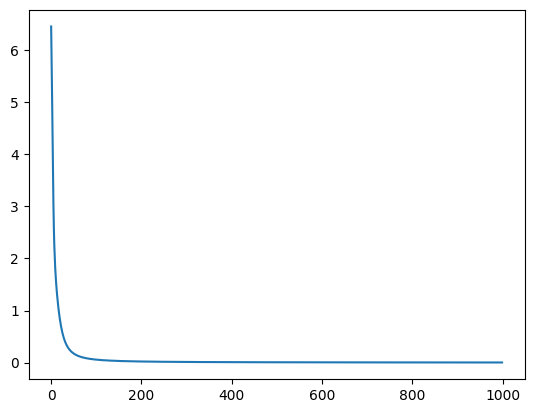

In [751]:
plt.plot(losses)

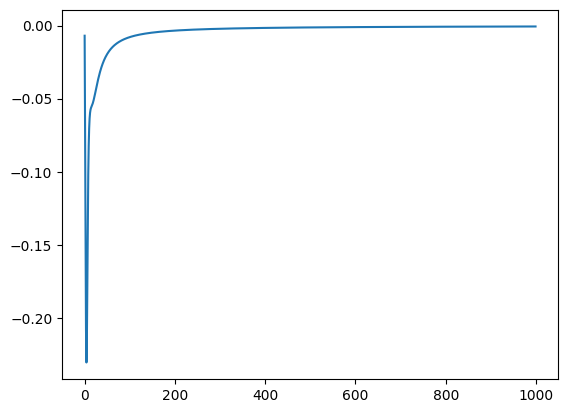

In [752]:
plt.plot(grad_avgs)

(array([ 1.,  1.,  0.,  1.,  3.,  3., 14.,  8.,  8.,  2.]),
 array([-0.01059869, -0.00911127, -0.00762384, -0.00613642, -0.004649  ,
        -0.00316158, -0.00167416, -0.00018674,  0.00130069,  0.00278811,
         0.00427553]),
 <BarContainer object of 10 artists>)

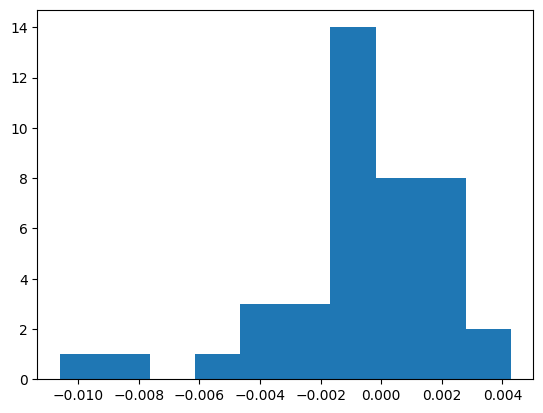

In [753]:
plt.hist([p.grad for p in n.params()])

In [757]:
## Exploding gradients

# reset params to start to compare
for p, ps in zip(n.params(), start_params_data):
    p.data = ps

[p.data for p in n.params()]

[0.36771558828719675,
 0.6853391217370621,
 -0.2749926978140609,
 0.86229635736161,
 0.4314590559765046,
 -0.711038155037234,
 -0.25749447573531725,
 -0.5581660793761483,
 0.24653762945246416,
 -0.248140386052762,
 0.39790689344347197,
 -0.3117519244926381,
 -0.1956308679889196,
 0.34717739209323395,
 -0.36884692150226406,
 -0.5532963944497655,
 0.804828964116064,
 0.4497842013767672,
 -0.7776920167151788,
 0.12438089734281488,
 -0.11800912694858479,
 0.19861619782342066,
 -0.6219544159440504,
 0.5026832556271095,
 -0.13739695139128982,
 0.04403924841301654,
 -0.11012180129960125,
 -0.6166896611323542,
 -0.192259852701546,
 -0.3257117116421353,
 0.6378762341861743,
 0.41179275128224213,
 0.8547605676289041,
 0.7942851395377977,
 0.3806614921891236,
 -0.21655363086578827,
 0.3229466163247612,
 0.20107081086984824,
 0.7352934951561538,
 0.9238806273724751,
 -0.9389621057431208]

In [758]:
LR = 0.01
iters = 1000
losses = []
grad_avgs = []

for _ in range(iters):
    ypred = [n(x) for x in xs]
    # print("predictions:\n", ypred)
    
    # MSE loss
    loss = sum([(ygt - yout)**2 for ygt, yout in zip(ypred, ys)])
    # print("loss = ", loss)
    losses.append(loss.data)
    # EXPLODE THE GRADIENTS
    # for p in n.params():
    #     p.grad = 0.0
    loss.backward()

    
    for p in n.params():
        p.data -= p.grad * LR
    
    # what do the gradients look like: gradient averages?
    grad_avg = sum([p.grad for p in n.params()]) / len(n.params())
    grad_avgs.append(grad_avg)

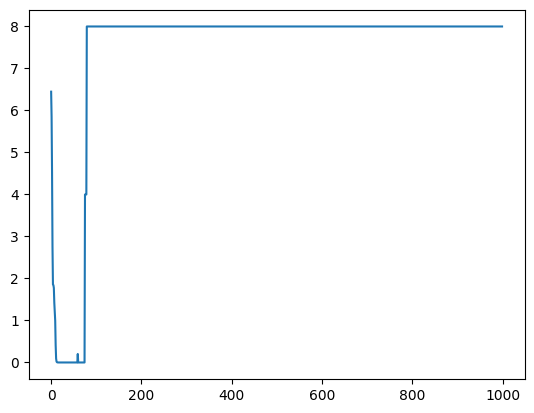

In [759]:
plt.plot(losses)

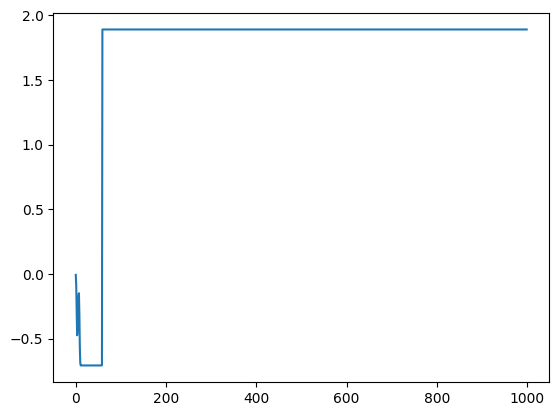

In [760]:
plt.plot(grad_avgs)

(array([ 1.,  4., 18., 15.,  1.,  1.,  0.,  0.,  0.,  1.]),
 array([-29.42039729, -18.82790417,  -8.23541104,   2.35708208,
         12.94957521,  23.54206833,  34.13456146,  44.72705458,
         55.31954771,  65.91204083,  76.50453396]),
 <BarContainer object of 10 artists>)

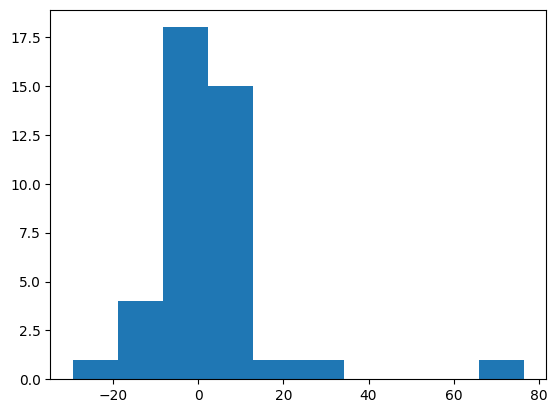

In [761]:
plt.hist([p.grad for p in n.params()])